In [4]:
import os
import sys

import numpy as np
import time
import pickle
from pprint import pprint
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from pyHalo.preset_models import CDM
from hydra import initialize, compose
from pyHalo.Cosmology.cosmology import Cosmology
import astropy.cosmology as astropy_cosmo

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import diagnostic_plot, plot
from mejiro.lenses.lens import Lens
from mejiro.lenses.test_physical_lens import TestPhysicalLens

np.random.seed(config.seed)

In [7]:
astropy = astropy_cosmo.default_cosmology.get()
cosmo = Cosmology(astropy_instance=astropy)

In [8]:
print(cosmo.astropy)

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)


In [4]:
lens = TestPhysicalLens()

In [5]:
realizationCDM = CDM(lens.z_lens, lens.z_source, cone_opening_angle_arcsec=10, LOS_normalization=0.0)
print(f'Realization contains {len(realizationCDM.halos)} halos.')

Realization contains 10135 halos.


Text(0, 0.5, 'n(M)')

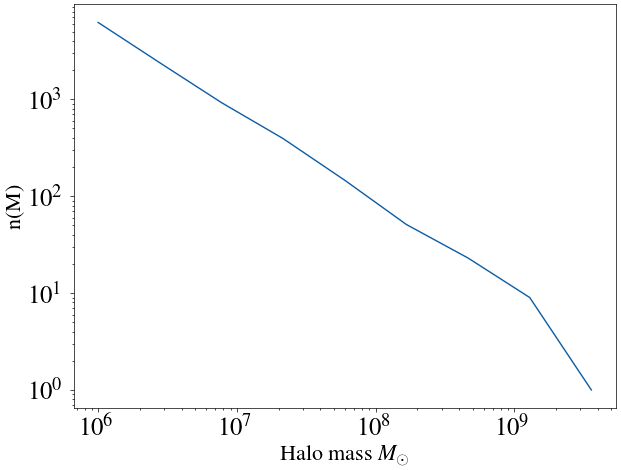

In [6]:
cdm_halo_masses = [halo.mass for halo in realizationCDM.halos]
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)

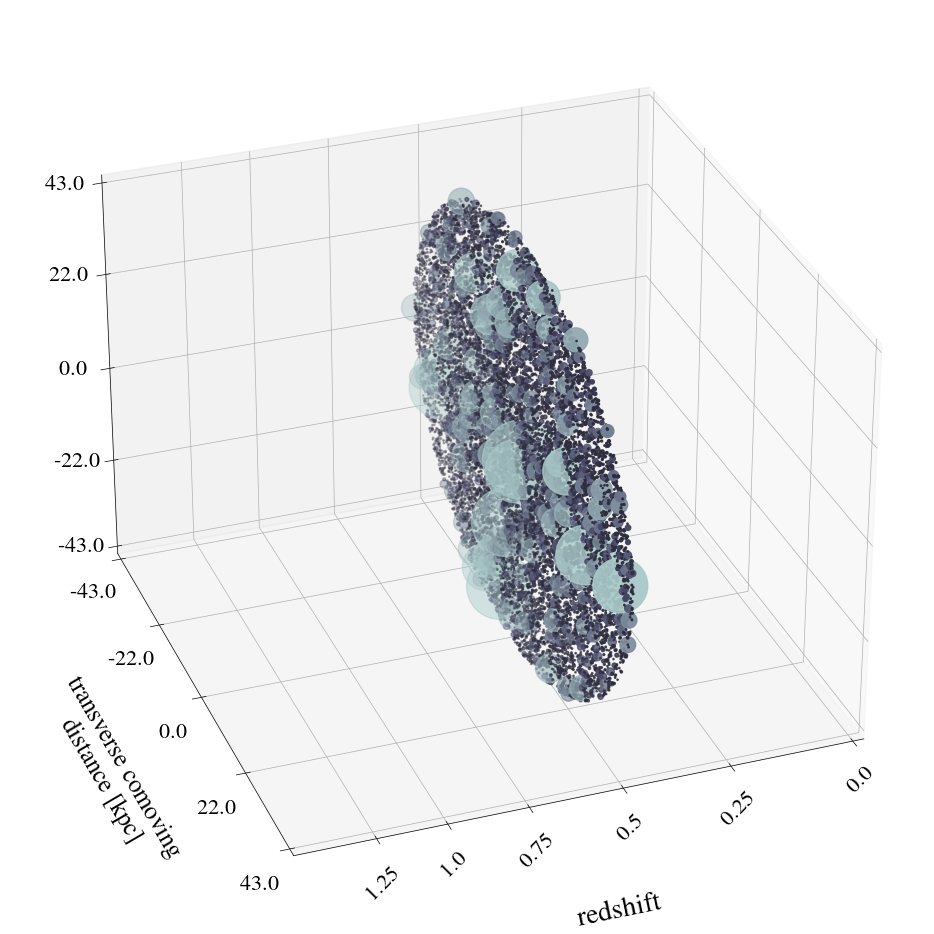

In [7]:
fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
realizationCDM.plot(ax)

In [8]:
halo_lens_model_list, halo_redshift_list, kwargs_halos, _ = realizationCDM.lensing_quantities()

# for some reason, halo_lens_model_list and kwargs_halos are lists, but halo_redshift_list is an ndarray
halo_redshift_list = halo_redshift_list.tolist()

lens_with_subhalos = TestPhysicalLens()

lens_with_subhalos.add_subhalos(halo_lens_model_list, halo_redshift_list, kwargs_halos)

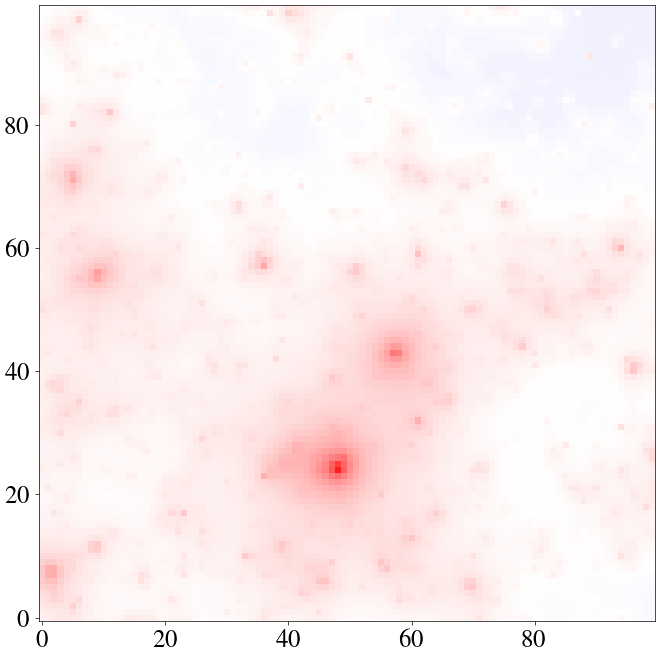

In [9]:
lens_model_halos_only = LensModel(halo_lens_model_list, lens.z_lens, lens.z_source, halo_redshift_list, cosmo=lens.cosmo, multi_plane=True)

npix = 100 
_x = _y = np.linspace(-1.2, 1.2, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa_subs = lens_model_halos_only.kappa(xx.ravel(), yy.ravel(), kwargs_halos).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_subs, vmin=-0.1, vmax=0.1, cmap='bwr')

In [10]:
plot.plot(lens_with_subhalos.get_array(num_pix=45))

TypeError: Lens.get_array() missing 1 required positional argument: 'side'

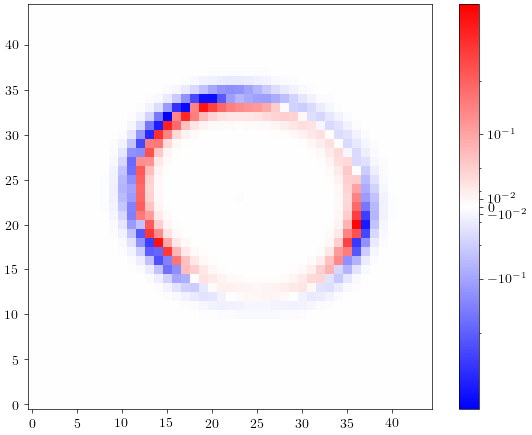

In [ ]:
diagnostic_plot.residual(lens.get_array(num_pix=45), lens_with_subhalos.get_array(num_pix=45))